In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd 
from modules import preprocessing as pp

%load_ext autoreload
%autoreload 2

## 1. Data import

#### Define the study crop and country

In [132]:
# USER INPUTS
ecmwf_country = "US" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path = ""
if ecmwf_country == "US":
    shapefile_path = '../data/shapefiles/US/tl_2023_us_county/tl_2023_us_county.shp'
elif ecmwf_country == "BR":
    shapefile_path = '../data/shapefiles/BR/bra_admbnda_adm2_ibge_2020.shp'

#### Read Data

<Axes: >

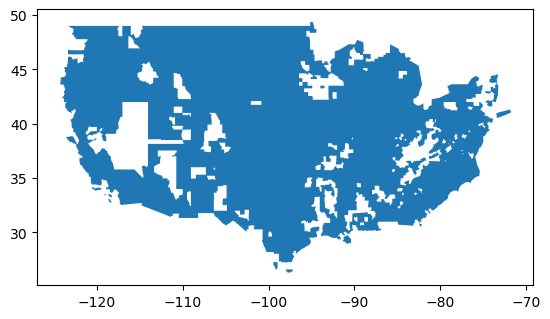

In [133]:
# CY-BENCH
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
era = pd.read_csv("../data/CY-Bench/{}/{}/meteo_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
relevant_adm_ids = yield_data["adm_id"].unique()
era = era.loc[era["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)

# Stella: 8-day time steps
start_dates = pd.read_csv("../data/annual_eight_day_bins.csv")
start_dates = start_dates.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))
day_of_year_to_time_step = start_dates.iloc[:, 0].dt.day_of_year.reset_index().set_index(start_dates.columns[0])["index"].to_dict()

# Country shapefile
country_gpd = gpd.read_file(shapefile_path)
country_gpd = country_gpd.set_crs("EPSG:4326", allow_override=True) # allow override because US shapefile is already in 4326
country_gpd["adm_id"] = ""
if ecmwf_country == "US":
    country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
if ecmwf_country == "BR":
    country_gpd["adm_id"] = country_gpd["ADM2_PCODE"]
mismatches = [adm_id for adm_id in relevant_adm_ids if adm_id not in country_gpd["adm_id"].unique()]
country_gpd = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
country_gpd_shape = country_gpd.dissolve().to_crs("EPSG:4326")
country_gpd_shape.plot()

#### Resample ERA to match 8-day bins

In [134]:
era = era.assign(date=pd.to_datetime(era["date"], format="%Y%m%d"), year=pd.to_datetime(era["date"], format="%Y%m%d").dt.year)

era_resampled = (era
                 .groupby(["adm_id", "year"]).resample("8D", on="date")[["tmin", "tmax", "prec", "tavg"]].mean().reset_index()
                 .rename(columns={"date":"start_date_bin"})
                 )

era_resampled = era_resampled.assign(time_step=era_resampled["start_date_bin"].apply(lambda x: day_of_year_to_time_step[x.day_of_year]))
era_resampled.sample(3)

,adm_id,year,start_date_bin,tmin,tmax,prec,tavg,time_step
1826907,US-40-055,2019,2019-05-17,16.949755,27.309907,19.152952,21.325148,17
384552,US-16-011,2007,2007-11-01,-1.512637,12.321540,0.000000,3.896694,38
1583187,US-37-059,2001,2001-02-10,3.755188,13.347446,6.661091,8.153672,5


## 2. Bring ERA and ECMWF together

Seasonal climate models (SCM) from ECMWF are initialized at the first of each month from January to December. The forecasts are provided for 7 months ahead. In-season yield forecasts will be validated throughout the season each time a new ECMWF forecasts is available at the beginning of each month. Below is an illustration of how ERA and SCM data will be concatenated depending on the month of initialization. Furthermore, since forecast length is up to 7 month, in-season yield forecast validation will start earliest 7 month before harvest. All past months will be consecutively supplemented wit AgERA5 data from CY-Bench each month as harvest is approached. See example wheat cropping season in Brazil from May to November (green dashed line) and in the US (blue dashed line) in the image below. For now, we will build the dataset from which crop calendars of arbitrary length (max. 7 month) can be extracted.


![title](../figures/era_scm_us_br_overview.png)

In [135]:
li = []
for ecmwf_init_month in ["jan", "feb", "mar", "apr", "may", "june", "july", "aug", "sep", "oct", "nov", "dec"]:
    
    ecmwf = (pd.read_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(ecmwf_country, ecmwf_init_month))
             .rename(columns={"t2m":"tavg", "tp":"prec", "mx2t24":"tmax", "mn2t24":"tmin"}))
    
    ecmwf = ecmwf.assign(valid_time=pd.to_datetime(ecmwf["valid_time"]), time=pd.to_datetime(ecmwf["time"]),
                        tavg=ecmwf["tavg"] - 273.15, tmax=ecmwf["tmax"] - 273.15, tmin=ecmwf["tmin"] - 273.15,
                        prec=ecmwf.groupby(["time", "latitude", "longitude"])["prec"].transform(lambda x: x.diff().fillna(x).clip(lower=0) * 1000))
    
    ecmwf = ecmwf.loc[ecmwf["time"].dt.year == ecmwf["valid_time"].dt.year].reset_index(drop=True)
    ecmwf_resampled = pp.resample_ecmwf(ecmwf, start_dates) 
    ecmwf_county_level = pp.assign_ecmwf_forecasts_to_counties(ecmwf_resampled, country_gpd, start_dates, "adm_id") 

    first_time_step = day_of_year_to_time_step[ecmwf_resampled["start_date_bin"].dt.day_of_year.min()]
    
    if ecmwf_init_month == "jan": 
        first_time_step = 0
        final_df = ecmwf_county_level.assign(year=ecmwf_county_level["init_date"].dt.year, init_month=ecmwf_county_level["init_date"].dt.month, init_time_step=first_time_step)
        li.append(final_df)
    else:
        era_filtered = era_resampled.loc[(era_resampled["start_date_bin"].dt.day_of_year < ecmwf_resampled["start_date_bin"].dt.day_of_year.min())].reset_index(drop=True)
        era_pivot = (era_filtered.assign(init_date = pd.to_datetime(era_filtered["start_date_bin"].dt.year.astype(str) + "-" + ecmwf_county_level["init_date"].dt.month.unique()[0].astype(str) + "-" + ecmwf_county_level["init_date"].dt.day.unique()[0].astype(str)))
                    .pivot(index=["adm_id", "init_date"], columns="time_step", values=["tavg", "tmin", "tmax", "prec"]))
        era_pivot.columns = ["_".join([str(col) for col in c]).strip() for c in era_pivot.columns]
        era_pivot = era_pivot.reset_index()
        final_df = ecmwf_county_level.merge(era_pivot, on=["adm_id", "init_date"], how="left").assign(year=ecmwf_county_level["init_date"].dt.year, init_month=ecmwf_county_level["init_date"].dt.month, init_time_step=first_time_step)
        li.append(final_df)

scm_era = pd.concat(li).set_index(["adm_id", "year", "init_month", "init_time_step"]).sort_index().drop("init_date", axis=1)

In [136]:
scm_era.to_csv("../data/preprocessed/{}/ecmwf_era_{}_{}.csv".format(ecmwf_country, crop, ecmwf_country))